# Assignment 2 Code Notebook

Jack Sparke | 13660507 | 05/11/2023

# Package and Library Import

In [3]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
import time
from sklearn.decomposition import PCA
from sklearn.cluster import MeanShift, estimate_bandwidth, AgglomerativeClustering
import pandas as pd
import pickle
from sklearn.utils import shuffle
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import metrics
from sklearn.metrics import rand_score
from sklearn.metrics.cluster import adjusted_rand_score, rand_score
from sklearn.cluster import KMeans, DBSCAN, HDBSCAN, OPTICS
from statistics import mean
from sklearn_extra.cluster import KMedoids
from sklearn_extra.cluster import CommonNNClustering
from sklearn.metrics.cluster import contingency_matrix

In [1]:

def combine_df():
    """
    Imports the data from each feature extraction method and merges it row-wise.
    
    Returns:
    combined_df (DataFrame): A DataFrame with each of the datasets merged row-wise.
    """
    filepath_list = [r"C:\Users\jacks\OneDrive - Bond University\233\AML\ASSIGN 1\FeatureExtraction_Tchebyshev_Mukundan2014_10Samples_perimage (1).dat",
             r"C:\Users\jacks\OneDrive - Bond University\233\AML\ASSIGN 1\FeatureExtraction_BGLBP_10samples_perimage2.dat",
             r"C:\Users\jacks\OneDrive - Bond University\233\AML\ASSIGN 1\FeatureExtraction_CSLBP_10samples_perimage2.dat",
             r"C:\Users\jacks\OneDrive - Bond University\233\AML\ASSIGN 1\FeatureExtraction_CSSILTP_10samples_perimage2.dat",
             r"C:\Users\jacks\OneDrive - Bond University\233\AML\ASSIGN 1\FeatureExtraction_SILTP_10samples_perimage2.dat",
             r"C:\Users\jacks\OneDrive - Bond University\233\AML\ASSIGN 1\FeatureExtraction_SCSLBP_10samples_perimage2.dat",
             r"C:\Users\jacks\OneDrive - Bond University\233\AML\ASSIGN 1\FeatureExtraction_OLBP_10Samples_perimage2.dat"
             ]


    counter =  0
    combined_df = None
    for path in filepath_list:
        df = pd.read_csv(path, header=None)
        
        if counter > 0:
            df = df.iloc[:, 3:]
        
        if combined_df is None:
            combined_df = df
        else:
            combined_df = pd.concat([combined_df, df], axis=1)
        counter += 1
        
    return combined_df


def dfs_in_list():
    """
    Imports each of the data in a list rather than into a merged DataFrame.
    
    Returns:
    df_list (list): A list of each DataFrame.
    """
    filepath_list = [r"C:\Users\jacks\OneDrive - Bond University\233\AML\ASSIGN 1\FeatureExtraction_Tchebyshev_Mukundan2014_10Samples_perimage (1).dat",
         r"C:\Users\jacks\OneDrive - Bond University\233\AML\ASSIGN 1\FeatureExtraction_BGLBP_10samples_perimage2.dat",
         r"C:\Users\jacks\OneDrive - Bond University\233\AML\ASSIGN 1\FeatureExtraction_CSLBP_10samples_perimage2.dat",
         r"C:\Users\jacks\OneDrive - Bond University\233\AML\ASSIGN 1\FeatureExtraction_CSSILTP_10samples_perimage2.dat",
         r"C:\Users\jacks\OneDrive - Bond University\233\AML\ASSIGN 1\FeatureExtraction_SILTP_10samples_perimage2.dat",
         r"C:\Users\jacks\OneDrive - Bond University\233\AML\ASSIGN 1\FeatureExtraction_SCSLBP_10samples_perimage2.dat",
         r"C:\Users\jacks\OneDrive - Bond University\233\AML\ASSIGN 1\FeatureExtraction_OLBP_10Samples_perimage2.dat"
         ]
    df_list = []
    for path in filepath_list:
        df = pd.read_csv(path, header=None)
        df_list.append(df)
        
    return df_list
        
    

def attr_name(df, df_name):
    """
    A function for adding interpretable names to the features of the data.
    Used when doing feature selection and to filter the data.
    
    The result feature names will be in the form: feature_extraction_methodCol_number.
    E.g., SILTP3, OLBP56, etc.
    
    Parameters:
    l (list): A list of the updated feature names.
    """
    df_fts = df.columns[3:]
    l = []
    for j in df_fts:
        h = df_name + str(j)
        l.append(h)
    
    return l
    

def importer():
    """
    A function used to import the data. 
    Column names are added, but unnecessary for the investigation.
    The y values is reduced by 1 for all classes, as the contingency matrix begins from 0.
    
    Returns:
    X (DataFrame): A DataFrame of the input data.
    y (Series): A series of the family target variable.
    """

    df_list = dfs_in_list()
    comb_df = combine_df()
    
    
    method_names = ['tchebyshev', 'bglbp', 'cslbp', 'cssiltp', 'siltp', 'scslbp', 'olbp']
    
    att_names = []
    
    
    for i in range(0, len(df_list)):
        df = df_list[i]
        l = attr_name(df, method_names[i])
        att_names.append(l)
        
    X = comb_df.drop([0,1,2], axis=1)
    y = comb_df[0].values
    
    att_names_ext = []

    
    for arr in att_names: # Extend the combined_data list with the elements from each array
        att_names_ext.extend(arr)
    
    X.columns = att_names_ext
    y = y-1 ## The contingency matrix begins classes from 0
    
    return X, y
    

def stratified_batches(X, y, num_batches=50, random_state=None):
    """
    A function used to get stratified batches without replacement. 
    Unless num_batches is indivisble to the length of X, each batch will be of equal size.
        Alternatively, the final batch will include what is left: len(X) % num_batches amount of samples. 
    The indices are returned rather than the data itself. 
    Can ensure reproducibility.
    
    Parameters:
    X (Array): Input data to be used to fit the model.
    y (Array): Class data to be used to fit the model.
    num_batches: The number of batches to be created. This is also the percentage size of the split. Default is 50.
    random_state: The seed to be used to ensure reproducibility. 
    
    Returns:
    Batches (List): A list of lists that include the indices to where the relative batch is located in the complete data. 
    """
    
    np.random.seed(random_state) # Ensure reproducibility

    unique_classes, class_counts = np.unique(y, return_counts=True)

    batch_size = len(X) // num_batches
    batches = []
    
    shuffled_classes = np.random.permutation(unique_classes) # Shuffle the order of unique classes

    for i in range(num_batches):
        batch_indices = []

        for cls in shuffled_classes: #  We can then add samples from each class to the batch until it reaches the desired size
            class_indices = np.where(y == cls)[0]
            if len(class_indices) > 0:
                num_to_add = min(batch_size // len(unique_classes), len(class_indices))
                batch_indices.extend(np.random.choice(class_indices, num_to_add, replace=False))


        np.random.shuffle(batch_indices) # Shuffle the batch indices

        batches.append(batch_indices)

    return batches

# Exploratory Data Analysis

First, we should visualise the data in the hyperspace to get an idea about the density.

We will use PCA to turn the data into 3 components, before plotting it in 3-Dimensions.


In [90]:
X, y = importer()
X = PCA(n_components=3).fit_transform(X)

A visualisation will be made for each subset of 15 increments of families as we expect a complete visualisation to be very dense. 

In [91]:
# producing 4 lists of each class from 1 to 60

r1 = range(1,15)
r2 = range(15,30)
r3 = range(30,45)
r4 = range(45,61)
l = [r1,r2,r3,r4]
c = []
for k in l:
    b = [x for x in k]
    c.append(b)


In [94]:
# Getting the indices to where each subset of families are located in the data

indi = []

for i in range(4):
    j = np.where(np.isin(y,c[i]))
    print(len(j[0]))
    indi.append(j)

74100
101200
88300
30230


A visualisation with 5 axes will be made, with 4 designated for each subset, and the final for the entire dataset.

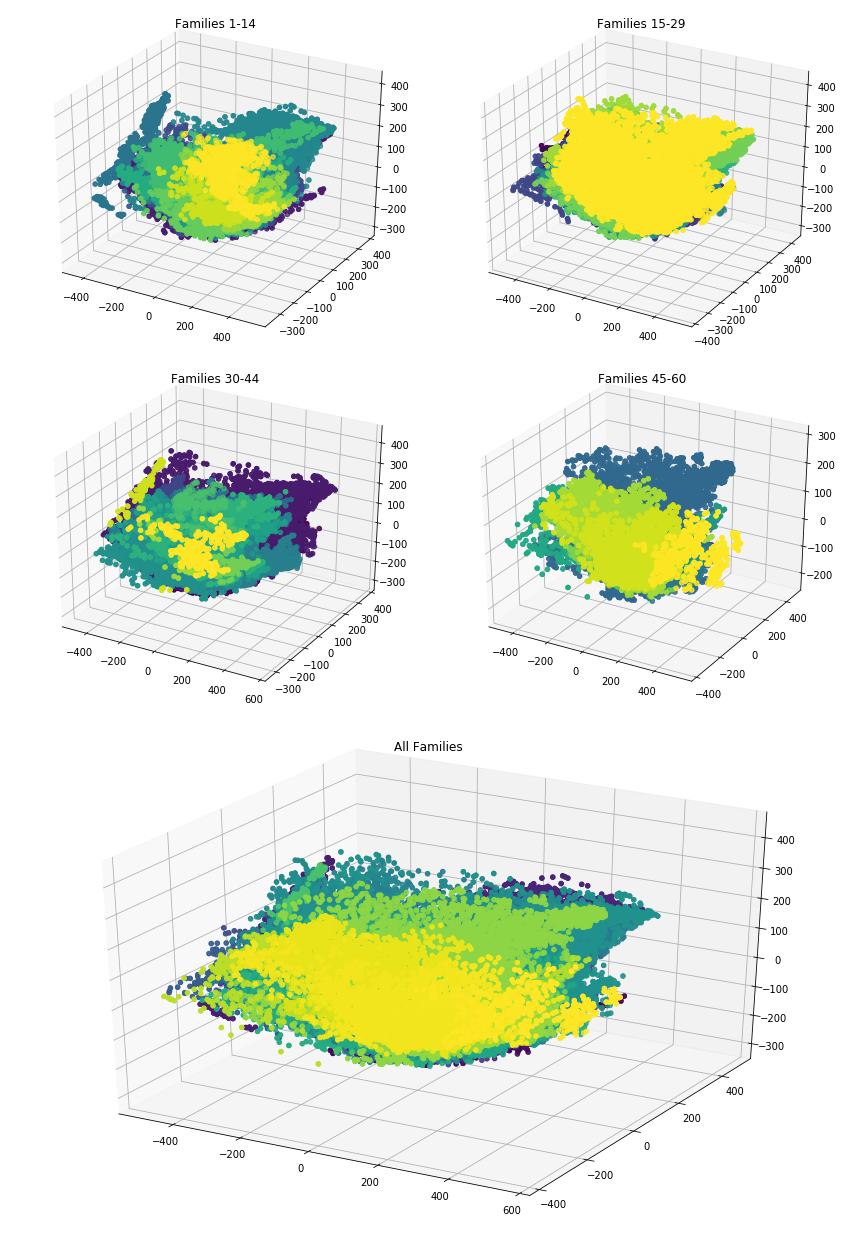

In [95]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib import gridspec

fig = plt.figure(figsize=(8, 12))
gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1.5])

axs = []
axs.append(plt.subplot(gs[0, 0], projection='3d'))
axs[0].scatter3D(X[indi[0],0], X[indi[0],1], X[indi[0],2], c=y[indi[0]])
axs[0].set_title('Families 1-14')

axs.append(plt.subplot(gs[0, 1], projection='3d'))
axs[1].scatter3D(X[indi[1],0], X[indi[1],1], X[indi[1],2], c=y[indi[1]])
axs[1].set_title('Families 15-29')

axs.append(plt.subplot(gs[1, 0], projection='3d'))
axs[2].scatter3D(X[indi[2],0], X[indi[2],1], X[indi[2],2], c=y[indi[2]])
axs[2].set_title('Families 30-44')

axs.append(plt.subplot(gs[1, 1], projection='3d'))
axs[3].scatter3D(X[indi[3],0], X[indi[3],1], X[indi[3],2], c=y[indi[3]])
axs[3].set_title('Families 45-60')


ax_large = plt.subplot(gs[2, :2], projection='3d')
ax_large.scatter3D(X[:,0], X[:,1], X[:,2], c=y)
ax_large.set_title('All Families')

plt.tight_layout(rect=[0, 0, 1.5, 1.44])
plt.show()


As we expected, there is significant denisty in the data, with no real structure evident.
This will likely produce weak clustering algorithms.

Next, to view distribution of the classes:

In [3]:
df_list = dfs_in_list()

for df in df_list:
    print(df.shape)

(293830, 62)
(293830, 57)
(293830, 18)
(293830, 110)
(293830, 82)
(293830, 19)
(293830, 206)


In [4]:
df = combine_df()

print(df.shape)

(293830, 536)


(array([    0.,  5000., 10000., 15000., 20000., 25000., 30000., 35000.]),
 [Text(0, 0.0, '0'),
  Text(0, 5000.0, '5000'),
  Text(0, 10000.0, '10000'),
  Text(0, 15000.0, '15000'),
  Text(0, 20000.0, '20000'),
  Text(0, 25000.0, '25000'),
  Text(0, 30000.0, '30000'),
  Text(0, 35000.0, '35000')])

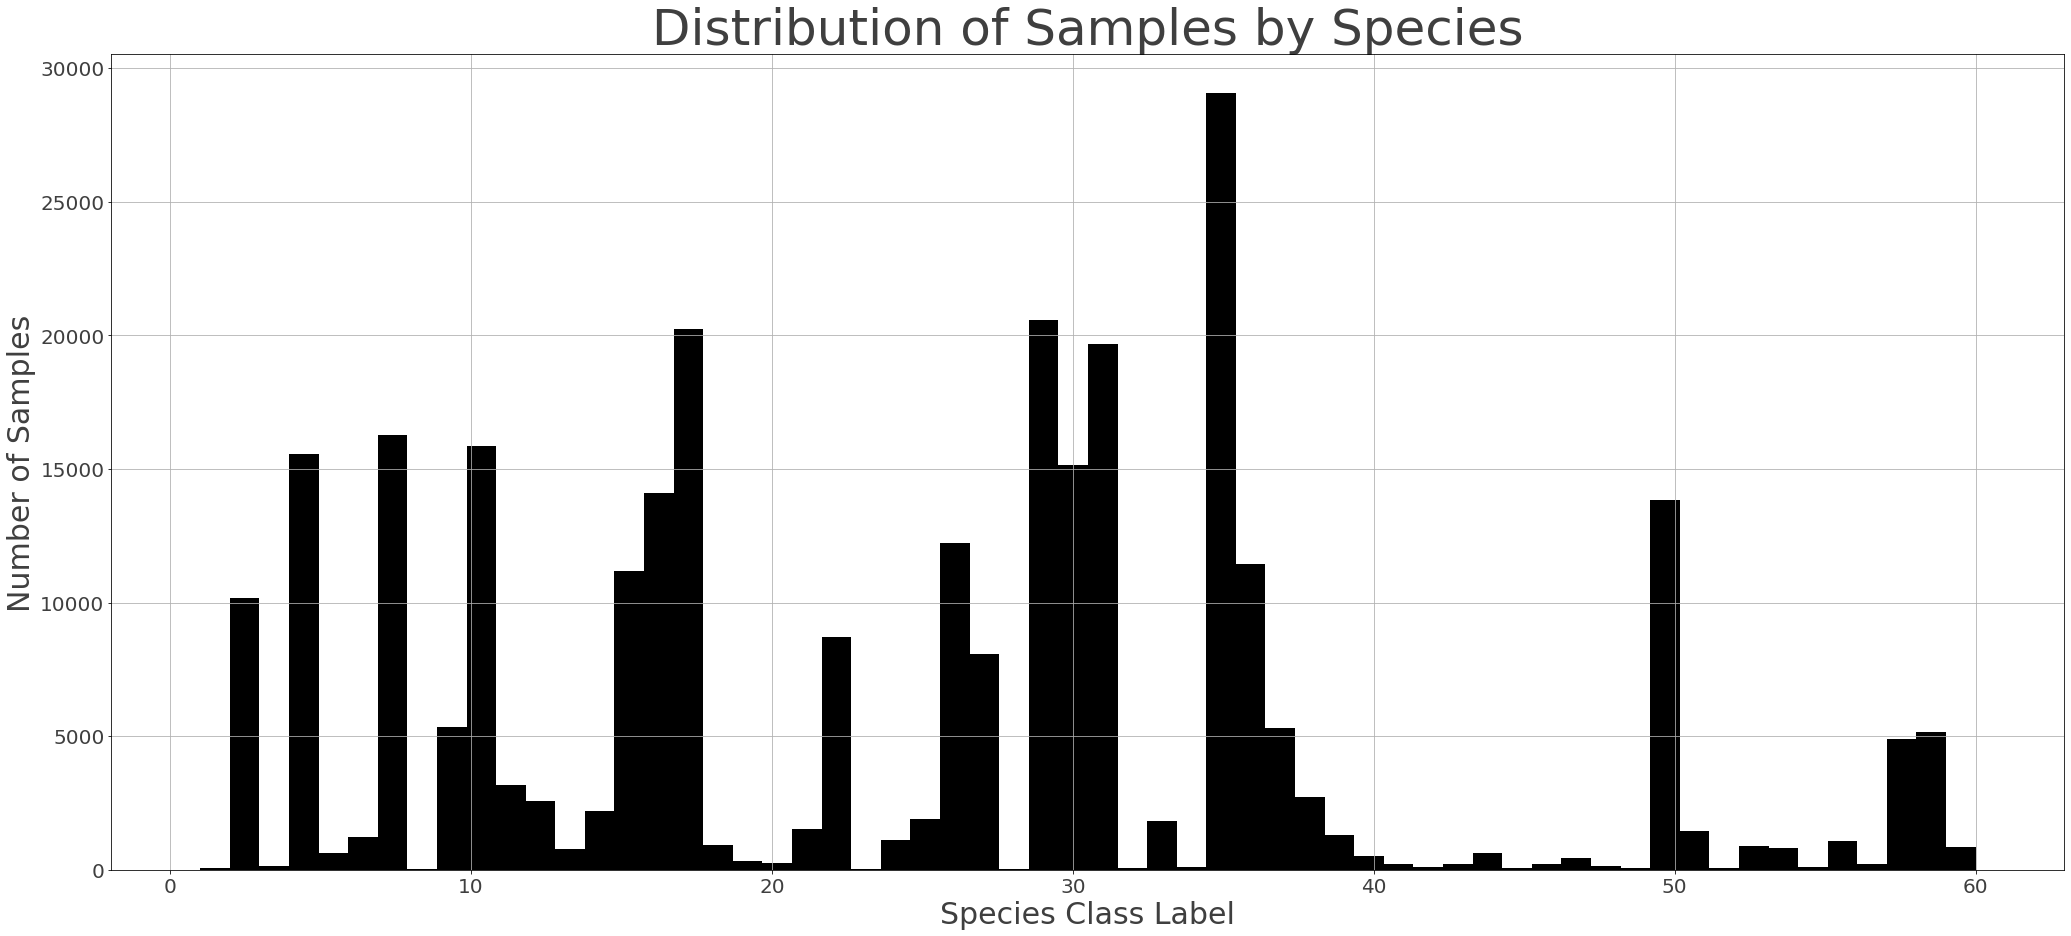

In [5]:

df[0].hist(bins=len(df[0].unique()) , figsize=(35, 15), color='black')
plt.title('Distribution of Samples by Family', fontsize=50, alpha=0.75)
plt.ylabel('Number of Samples', fontsize=30, alpha=0.75)
plt.xlabel('Species Class Label', fontsize=30, alpha=0.75)
plt.xticks(rotation=0, fontsize=20, alpha=0.75)
plt.yticks(rotation=0, fontsize=20, alpha=0.75)


# Feature Selection and K-Means Testings

The following will be completed to test the effects of scaling the data on clustering algorithms.
The feature engineerings methods will be:
- A standard scaler; Z-Score Normalisation
- Minimum Maximum Scaler
- Original dataset 

## Standard Scaler

In [ ]:
X, y = importer()
X = StandardScaler().fit_transform(X)

algo = KMeans(init="k-means++", n_clusters=60, n_init='auto', random_state=8)
st = time.time()
algo.fit(X)
ed = time.time()
elapsed_time = ed - st
print(elapsed_time)
y_pred = algo.predict(X)


cm = contingency_matrix(y_pred, y)

clus_dict = {}
total_sum = []
families = []
ave_props = []

for i in range(0,60):
    g = {}
    if max(cm[:,i]) == max(cm[np.argmax(cm[:,i]),:]):
        g['num'] = max(cm[:,i])
        g['cluster'] = np.argmax(cm[:,i])
        g['family'] = np.argmax(cm[np.argmax(cm[:,i]),:])
        j = max(cm[np.argmax(cm[:,i]),:])/sum(cm[np.argmax(cm[:,i]),:])
        g['prop_of_cluster'] = j
        ave_props.append(j)
        clus_dict[i] = g
        total_sum.append(max(cm[:,i]))
        families.append(np.argmax(cm[np.argmax(cm[:,i]),:]))
    else:
        clus_dict[i] = 'no match'

print('Total percentage of samples in correctly assigned clusters: ',sum(total_sum)/len(y))
print('Number of families correctly assigned: ', len(families))
print('Average purity of correctly assigned clusters', mean(ave_props))
        
print('Adjusted Rand Index', adjusted_rand_score(y, y_pred))
print('Silhouette Score', metrics.silhouette_score(X, y_pred))

## Minimum Maximum Scaler

In [ ]:
X, y = importer()
X = MinMaxScaler().fit_transform(X)

algo = KMeans(init="k-means++", n_clusters=60, n_init='auto', random_state=8)
st = time.time()
algo.fit(X)
ed = time.time()
elapsed_time = ed - st
print(elapsed_time)
y_pred = algo.predict(X)

cm = contingency_matrix(y_pred, y)

clus_dict = {}
total_sum = []
families = []
ave_props = []

for i in range(0,60):
    g = {}
    if max(cm[:,i]) == max(cm[np.argmax(cm[:,i]),:]):
        g['num'] = max(cm[:,i])
        g['cluster'] = np.argmax(cm[:,i])
        g['family'] = np.argmax(cm[np.argmax(cm[:,i]),:])
        j = max(cm[np.argmax(cm[:,i]),:])/sum(cm[np.argmax(cm[:,i]),:])
        g['prop_of_cluster'] = j
        ave_props.append(j)
        clus_dict[i] = g
        total_sum.append(max(cm[:,i]))
        families.append(np.argmax(cm[np.argmax(cm[:,i]),:]))
    else:
        clus_dict[i] = 'no match'

print('Total percentage of samples in correctly assigned clusters: ',sum(total_sum)/len(y))
print('Number of families correctly assigned: ', len(families))
print('Average purity of correctly assigned clusters', mean(ave_props))
        
print('Adjusted Rand Index', adjusted_rand_score(y, y_pred))
print('Silhouette Score', metrics.silhouette_score(X, y_pred))

## Original Dataset

In [ ]:
X, y = importer()

algo = KMeans(init="k-means++", n_clusters=60, n_init='auto', random_state=8)
st = time.time()
algo.fit(X)
ed = time.time()
elapsed_time = ed - st
print(elapsed_time)
y_pred = algo.predict(X)


cm = contingency_matrix(y_pred, y)

clus_dict = {}
total_sum = []
families = []
ave_props = []

for i in range(0,60):
    g = {}
    if max(cm[:,i]) == max(cm[np.argmax(cm[:,i]),:]):
        g['num'] = max(cm[:,i])
        g['cluster'] = np.argmax(cm[:,i])
        g['family'] = np.argmax(cm[np.argmax(cm[:,i]),:])
        j = max(cm[np.argmax(cm[:,i]),:])/sum(cm[np.argmax(cm[:,i]),:])
        g['prop_of_cluster'] = j
        ave_props.append(j)
        clus_dict[i] = g
        total_sum.append(max(cm[:,i]))
        families.append(np.argmax(cm[np.argmax(cm[:,i]),:]))
    else:
        clus_dict[i] = 'no match'

print('Total percentage of samples in correctly assigned clusters: ',sum(total_sum)/len(y))
print('Number of families correctly assigned: ', len(families))
print('Average purity of correctly assigned clusters', mean(ave_props))
        
print('Adjusted Rand Index', adjusted_rand_score(y, y_pred))
print('Silhouette Score', metrics.silhouette_score(X, y_pred))

The fastest runtime of the feature selection is as ranked as follows:
- Originalk Dataset
- MinMax Scaled Dataset
- Standard Scaled Dataset

Interestingly, the standard dataset has the fastest runtime on K-Means.

The best performing feature engineered dataset according to the adjusted rand index:
- Standard Scaled Dataset
- MinMax Scaled Dataset
- Original Dataset

Because of its performance, the standard scaled dataset will be utilised for all future testing. 
Results for K-Means showed relatively low adjusted rand index scores. This will be used as the benchmark for future clustering algorithms. 

# K-Medoids 

K-Medoids will be tested, with each algorithm's distance metric altered.

In [ ]:
## DO NOT RUN, WILL GET MEMORY ERROR
# X, y = importer()
# X = StandardScaler().fit_transform(X)
# mets = ['cosine', 'manhattan', 'euclidean']

# for met in mets:

#     algo = KMedoids(metric='euclidean', n_clusters=60)
#     algo.fit(Xv)

Due to runtime error, a subset of 10% of the data will be used.
This will be done by using the pre-existing batch training function that will be used for future clustering algorithms.
By setting num_batches to 10, 10 equally sized, and stratified, batches will be created.
The first will be used to subset. Setting random_state will ensure that the batch indices will be consistent for future clustering models. 

In [ ]:
X, y = importer()
X = StandardScaler().fit_transform(X)

batches = stratified_batches(X, y, num_batches=10, random_state=8)
Xv = X[batches[0]]
yv = y[batches[0]]

mets = ['cosine', 'manhattan', 'euclidean']

for met in mets:
    
    print(met)
    print('###########################################################')
    algo = KMedoids(metric=met, n_clusters=60)
    algo.fit(Xv)

    y_pred = algo.predict(Xv)

    cm = contingency_matrix(y_pred, yv)

    clus_dict = {}
    total_sum = []
    families = []
    ave_props = []

    for i in range(0,60):
        g = {}
        if max(cm[:,i]) == max(cm[np.argmax(cm[:,i]),:]):
            g['num'] = max(cm[:,i])
            g['cluster'] = np.argmax(cm[:,i])
            g['family'] = np.argmax(cm[np.argmax(cm[:,i]),:])
            j = max(cm[np.argmax(cm[:,i]),:])/sum(cm[np.argmax(cm[:,i]),:])
            g['prop_of_cluster'] = j
            ave_props.append(j)
            clus_dict[i] = g
            total_sum.append(max(cm[:,i]))
            families.append(np.argmax(cm[np.argmax(cm[:,i]),:]))
        else:
            clus_dict[i] = 'no match'

    print('Total percentage of samples in correctly assigned clusters: ',sum(total_sum)/len(yv))
    print('Number of families correctly assigned: ', len(families))
    print('Average purity of correctly assigned clusters', mean(ave_props))

    print('Adjusted Rand Index', adjusted_rand_score(yv, y_pred))
    print('Silhouette Score', metrics.silhouette_score(Xv, y_pred))
    print('###########################################################')
    print('')



The cosine metric was the best performing algorithm. 

K-Medoid shows significant improvment over the K-Means algorithm.
This is likely due to a subset of the total data being used.
To test this, the subset will be trained on the K-Means algorithm to see differences. 

In [ ]:
algo = KMeans(init="k-means++", n_clusters=60, n_init='auto', random_state=8)
algo.fit(Xv)

y_pred = algo.predict(Xv)

cm = contingency_matrix(y_pred, yv)

clus_dict = {}
total_sum = []
families = []
ave_props = []

for i in range(0,60):
    g = {}
    if max(cm[:,i]) == max(cm[np.argmax(cm[:,i]),:]):
        g['num'] = max(cm[:,i])
        g['cluster'] = np.argmax(cm[:,i])
        g['family'] = np.argmax(cm[np.argmax(cm[:,i]),:])
        j = max(cm[np.argmax(cm[:,i]),:])/sum(cm[np.argmax(cm[:,i]),:])
        g['prop_of_cluster'] = j
        ave_props.append(j)
        clus_dict[i] = g
        total_sum.append(max(cm[:,i]))
        families.append(np.argmax(cm[np.argmax(cm[:,i]),:]))
    else:
        clus_dict[i] = 'no match'

print('Total percentage of samples in correctly assigned clusters: ',sum(total_sum)/len(yv))
print('Number of families correctly assigned: ', len(families))
print('Average purity of correctly assigned clusters', mean(ave_props))

print('Adjusted Rand Index', adjusted_rand_score(yv, y_pred))
print('Silhouette Score', metrics.silhouette_score(Xv, y_pred))

In [ ]:
print(cm)

There is significant improvements when using a subset of data. This will try and be avoided for future testing; however, if not possible, this subset strategy will be used. 

# Agglomerative Clustering

In [ ]:
# links = ['ward', 'single', 'average', 'complete']

# for link in links:
    
#     print(link)
#     print('###########################################################')
#     algo = AgglomerativeClustering(linkage=link, n_clusters=60)
#     algo.fit(X)

#     y_pred = algo.predict(X)

#     cm = contingency_matrix(y_pred, y)

#     clus_dict = {}
#     total_sum = []
#     families = []
#     ave_props = []

#     for i in range(0,60):
#         g = {}
#         if max(cm[:,i]) == max(cm[np.argmax(cm[:,i]),:]):
#             g['num'] = max(cm[:,i])
#             g['cluster'] = np.argmax(cm[:,i])
#             g['family'] = np.argmax(cm[np.argmax(cm[:,i]),:])
#             j = max(cm[np.argmax(cm[:,i]),:])/sum(cm[np.argmax(cm[:,i]),:])
#             g['prop_of_cluster'] = j
#             ave_props.append(j)
#             clus_dict[i] = g
#             total_sum.append(max(cm[:,i]))
#             families.append(np.argmax(cm[np.argmax(cm[:,i]),:]))
#         else:
#             clus_dict[i] = 'no match'

#     print('Total percentage of samples in correctly assigned clusters: ',sum(total_sum)/len(y))
#     print('Number of families correctly assigned: ', len(families))
#     print('Average purity of correctly assigned clusters', mean(ave_props))

#     print('Adjusted Rand Index', adjusted_rand_score(y, y_pred))
#     print('Silhouette Score', metrics.silhouette_score(X, y_pred))
#     print('###########################################################')
#     print('')

Getting the same memory issues, the subset will be used. 

In [ ]:
batches = stratified_batches(X, y, num_batches=10, random_state=8)
Xv = X[batches[0]]
yv = y[batches[0]]
cm_dict = {}

for link in links:
    
    print(link)
    print('###########################################################')
    algo = AgglomerativeClustering(linkage=link, n_clusters=60)
    algo.fit(X)

    y_pred = algo.predict(X)
    
    cm = contingency_matrix(y_pred, y)
    cm_dict[link] = cm
    
    clus_dict = {}
    total_sum = []
    families = []
    ave_props = []

    for i in range(0,60):
        g = {}
        if max(cm[:,i]) == max(cm[np.argmax(cm[:,i]),:]):
            g['num'] = max(cm[:,i])
            g['cluster'] = np.argmax(cm[:,i])
            g['family'] = np.argmax(cm[np.argmax(cm[:,i]),:])
            j = max(cm[np.argmax(cm[:,i]),:])/sum(cm[np.argmax(cm[:,i]),:])
            g['prop_of_cluster'] = j
            ave_props.append(j)
            clus_dict[i] = g
            total_sum.append(max(cm[:,i]))
            families.append(np.argmax(cm[np.argmax(cm[:,i]),:]))
        else:
            clus_dict[i] = 'no match'

    print('Total percentage of samples in correctly assigned clusters: ',sum(total_sum)/len(y))
    print('Number of families correctly assigned: ', len(families))
    print('Average purity of correctly assigned clusters', mean(ave_props))

    print('Adjusted Rand Index', adjusted_rand_score(y, y_pred))
    print('Silhouette Score', metrics.silhouette_score(X, y_pred))
    print('###########################################################')
    print('')

In [ ]:
## The 'single' and 'average' link types are producing abnormal results.
# We will investigate further

print(cm['single'])

In [ ]:
print(cm['average'])

It seems that all the data was put into 1 cluster, with the other 59 being populated with 5-10 datapoints. 
No meaningful results.

Alternatively, the 'ward' and 'complete' linked agglomerative clustering produced comparatively good results. However, still not as good as K-Medoids

# DBSCAN 

Firstly, investigation will be done into the number of samples required.

In [ ]:
X, y = importer()
X = StandardScaler().fit_transform(X)

batches = stratified_batches(X, y, num_batches=50, random_state=8)

for j in [10,25,50,100]:
    met_dict[f'{j}'] = {}
    sils=[]
    rands = []
    adj_rands = []

    for batch_indices in batches:
        X_batch = X[batch_indices]
        y_batch = y[batch_indices]
        
        algo = DBSCAN(eps=5, min_samples = j)
        algo.fit(X_batch)
        labels = algo.labels_
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        if n_clusters_ <= 1:
            print('batch failed due to small number of clusters', j)
            break
        else:
            print('Cluster number: ' + n_clusters_ +'  for min_samples: ' + j)
            q = metrics.silhouette_score(X_batch, labels)
            sils.append(q)
            w = rand_score(y_batch, labels)
            rands.append(w)
            e = adjusted_rand_score(y_batch, labels)
            adj_rands.append(e)
    if len(sils) == 0:
        continue
    else:        
        met_dict[f'{j}']['sil'] = (mean(sils))
        met_dict[f'{j}']['rand'] = (mean(rands))
        
        met_dict[f'{j}']['adj_rand'] = (mean(adj_rands))
        met_dict[f'{j}']['rand_std'] = np.std(adj_rands)
    print('iteration done')
    
print(met_dict)

For a min_sample of 10 and 25, a significantly large number of clusters are formed.
For a min_sample of 100, no cluster is formed.

50 seems appropriate. 

Choosing the right value for the epsilon, or radius of the cluster. 

In [ ]:
X, y = importer()
X = StandardScaler().fit_transform(X)
met_dict = {}


for j in range(2,20,2):
    met_dict[f'{j}'] = {}
    sils=[]
    rands = []
    adj_rands = []

    for batch_indices in batches:
        X_batch = X[batch_indices]
        y_batch = y[batch_indices]
        
        algo = DBSCAN(eps=j, min_samples = 50)
        algo.fit(X_batch)
        labels = algo.labels_
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        if n_clusters_ <= 1:
            print('batch failed due to small number of clusters', j)
            continue
        else:
            print('Cluster number: ' + n_clusters_ +'  for epsilon: ' + j)
            q = metrics.silhouette_score(X_batch, labels)
            sils.append(q)
            w = rand_score(y_batch, labels)
            rands.append(w)
            e = adjusted_rand_score(y_batch, labels)
            adj_rands.append(e)
    if len(sils) == 0:
        continue
    else:        
        met_dict[f'{j}']['sil'] = (mean(sils))
        met_dict[f'{j}']['rand'] = (mean(rands))
        
        met_dict[f'{j}']['adj_rand'] = (mean(adj_rands))
        met_dict[f'{j}']['rand_std'] = np.std(adj_rands)

    print('iteration done')
    
print(met_dict)

12 seems to be the best value for epsilon, both in the fact that it produced clusters and its adjusted rand index. 

In [ ]:
X, y = importer()
X = StandardScaler().fit_transform(X)

algo = DBSCAN(eps=12, min_samples = 50, n_jobs=-1) ## set n_jobs to -1 so all cores are used. 
algo.fit(X)
labels = algo.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print('Number of clusters: ', n_clusters_)
n_noise_ = list(labels).count(-1)
prop_noise = n_noise_/len(X)
print('Percentage of total data that is noise: ', prop_noise)

cm = contingency_matrix(labels, y)

clus_dict = {}
total_sum = []
families = []
ave_props = []

for i in range(0,n_clusters_):
    g = {}
    if max(cm[:,i]) == max(cm[np.argmax(cm[:,i]),:]):
        g['num'] = max(cm[:,i])
        g['cluster'] = np.argmax(cm[:,i])
        g['family'] = np.argmax(cm[np.argmax(cm[:,i]),:])
        j = max(cm[np.argmax(cm[:,i]),:])/sum(cm[np.argmax(cm[:,i]),:])
        g['prop_of_cluster'] = j
        ave_props.append(j)
        clus_dict[i] = g
        total_sum.append(max(cm[:,i]))
        families.append(np.argmax(cm[np.argmax(cm[:,i]),:]))
    else:
        clus_dict[i] = 'no match'

print('Total percentage of samples in correctly assigned clusters: ',sum(total_sum)/len(y))
print('Number of families correctly assigned: ', len(families))
print('Average purity of correctly assigned clusters', mean(ave_props))

print('Adjusted Rand Index', adjusted_rand_score(y, y_pred))
print('Silhouette Score', metrics.silhouette_score(X, y_pred))

In [ ]:
print(cm)

Only 1 family was correctly assigned, with only 5 clusters produced using the algorithm. 
The family assigned has a small number of samples and is contained in a relatively small cluster, evidenced by the 95.1% purity of the clusters, whilst the sample being 0.26% of the entire data. 

This is furthered by the very low adjusted rand index.

# HDBSCAN

HDBSCAN is an extension of DBSCAN and shares the min_samples hyperparameter. This will be retained at 50 for all future density-based clustering algorithms. 

In [ ]:
X, y = importer()
X = StandardScaler().fit_transform(X)
met_dict = {}


for j in range(10,80,5):
    met_dict[f'{j}'] = {}
    sils=[]
    rands = []
    adj_rands = []

    for batch_indices in batches:
        X_batch = X[batch_indices]
        y_batch = y[batch_indices]
        
        algo = HDBSCAN(min_cluster_size=j, min_samples = 50)
        algo.fit(X_batch)
        labels = algo.labels_
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        if n_clusters_ <= 1:
            print('batch failed due to small number of clusters', j)
            continue
        else:
            print('Cluster number: ' + n_clusters_ +'  for min_cluster_size: ' + j)
            q = metrics.silhouette_score(X_batch, labels)
            sils.append(q)
            w = rand_score(y_batch, labels)
            rands.append(w)
            e = adjusted_rand_score(y_batch, labels)
            adj_rands.append(e)
    if len(sils) == 0:
        continue
    else:        
        met_dict[f'{j}']['sil'] = (mean(sils))
        met_dict[f'{j}']['rand'] = (mean(rands))
        
        met_dict[f'{j}']['adj_rand'] = (mean(adj_rands))
        met_dict[f'{j}']['rand_std'] = np.std(adj_rands)

    print('iteration done')
    
print(met_dict)

50 appears to be the best value for the minimum number of samples to be considered a cluster.

In [ ]:
algo = HDBSCAN(min_cluster_size=50, min_samples = 50, n_jobs=-1)
algo.fit(X)
labels = algo.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print('Number of clusters: ', n_clusters_)
n_noise_ = list(labels).count(-1)
prop_noise = n_noise_/len(X)
print('Percentage of total data that is noise: ', prop_noise)

cm = contingency_matrix(labels, y)

clus_dict = {}
total_sum = []
families = []
ave_props = []

for i in range(0,n_clusters_):
    g = {}
    if max(cm[:,i]) == max(cm[np.argmax(cm[:,i]),:]):
        g['num'] = max(cm[:,i])
        g['cluster'] = np.argmax(cm[:,i])
        g['family'] = np.argmax(cm[np.argmax(cm[:,i]),:])
        j = max(cm[np.argmax(cm[:,i]),:])/sum(cm[np.argmax(cm[:,i]),:])
        g['prop_of_cluster'] = j
        ave_props.append(j)
        clus_dict[i] = g
        total_sum.append(max(cm[:,i]))
        families.append(np.argmax(cm[np.argmax(cm[:,i]),:]))
    else:
        clus_dict[i] = 'no match'

print('Total percentage of samples in correctly assigned clusters: ',sum(total_sum)/len(y))
print('Number of families correctly assigned: ', len(families))
print('Average purity of correctly assigned clusters', mean(ave_props))

print('Adjusted Rand Index', adjusted_rand_score(y, y_pred))
print('Silhouette Score', metrics.silhouette_score(X, y_pred))

In [ ]:
print(cm)

No clusters are considered correctly assigned using the HDBSCAN algorithm.

# OPTICS 

The documentation states that the OPTICS model is closely related to DBSCAN. 
Therefore, we know that the optimised epsilon value in DBSCAN was 12, so we will set a range around this value. 

In [ ]:
X, y = importer()
X = StandardScaler().fit_transform(X)
met_dict = {}


for j in range(2,20,2):
    met_dict[f'{j}'] = {}
    sils=[]
    rands = []
    adj_rands = []

    for batch_indices in batches:
        X_batch = X[batch_indices]
        y_batch = y[batch_indices]
        
        algo = OPTICS(max_eps=j, min_samples = 50)
        algo.fit(X_batch)
        labels = algo.labels_
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        if n_clusters_ <= 1:
            print('batch failed due to small number of clusters', j)
            continue
        else:
            print('Cluster number: ' + n_clusters_ +'  for max eps: ' + j)
            q = metrics.silhouette_score(X_batch, labels)
            sils.append(q)
            w = rand_score(y_batch, labels)
            rands.append(w)
            e = adjusted_rand_score(y_batch, labels)
            adj_rands.append(e)
    if len(sils) == 0:
        continue
    else:        
        met_dict[f'{j}']['sil'] = (mean(sils))
        met_dict[f'{j}']['rand'] = (mean(rands))
        
        met_dict[f'{j}']['adj_rand'] = (mean(adj_rands))
        met_dict[f'{j}']['rand_std'] = np.std(adj_rands)

    print('iteration done')
    
print(met_dict)

As expected, 12 seems to be best max_eps value for the OPTICS model on this data; this argument is the same as the eps parameer in DBSCAN. 

In [ ]:
algo = OPTICS(max_eps=12, min_samples=50, n_jobs=-1)
algo.fit(X)
labels = algo.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print('Number of clusters: ', n_clusters_)
n_noise_ = list(labels).count(-1)
prop_noise = n_noise_/len(X)
print('Percentage of total data that is noise: ', prop_noise)

cm = contingency_matrix(labels, y)

clus_dict = {}
total_sum = []
families = []
ave_props = []

for i in range(0,n_clusters_):
    g = {}
    if max(cm[:,i]) == max(cm[np.argmax(cm[:,i]),:]):
        g['num'] = max(cm[:,i])
        g['cluster'] = np.argmax(cm[:,i])
        g['family'] = np.argmax(cm[np.argmax(cm[:,i]),:])
        j = max(cm[np.argmax(cm[:,i]),:])/sum(cm[np.argmax(cm[:,i]),:])
        g['prop_of_cluster'] = j
        ave_props.append(j)
        clus_dict[i] = g
        total_sum.append(max(cm[:,i]))
        families.append(np.argmax(cm[np.argmax(cm[:,i]),:]))
    else:
        clus_dict[i] = 'no match'

print('Total percentage of samples in correctly assigned clusters: ',sum(total_sum)/len(y))
print('Number of families correctly assigned: ', len(families))
print('Average purity of correctly assigned clusters', mean(ave_props))

print('Adjusted Rand Index', adjusted_rand_score(y, y_pred))
print('Silhouette Score', metrics.silhouette_score(X, y_pred))

In [ ]:
print(cm)

The results for the OPTICS algorithm is identical to the DBSCAN algorithm results, with slight variations to the intra-cluster values. 

# Meanshift

With the Meanshift clustering algorithm 

In [ ]:
X, y = importer()
X = StandardScaler().fit_transform(X)

bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=len(X))
algo = MeanShift(bandwidth=bandwidth, bin_seeding=False, n_jobs = -1)
algo.fit(X)
labels = algo.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print('Number of clusters: ', n_clusters_)
n_noise_ = list(labels).count(-1)
prop_noise = n_noise_/len(X)
print('Percentage of total data that is noise: ', prop_noise)

from sklearn.metrics.cluster import contingency_matrix

cm = contingency_matrix(labels, y)

clus_dict = {}
total_sum = []
families = []
ave_props = []

for i in range(0,1):
    g = {}
    if max(cm[:,i]) == max(cm[np.argmax(cm[:,i]),:]):
        g['num'] = max(cm[:,i])
        g['cluster'] = np.argmax(cm[:,i])
        g['family'] = np.argmax(cm[np.argmax(cm[:,i]),:])
        j = max(cm[np.argmax(cm[:,i]),:])/sum(cm[np.argmax(cm[:,i]),:])
        g['prop_of_cluster'] = j
        ave_props.append(j)
        clus_dict[i] = g
        total_sum.append(max(cm[:,i]))
        families.append(np.argmax(cm[np.argmax(cm[:,i]),:]))
    else:
        clus_dict[i] = 'no match'

print('Total percentage of samples in correctly assigned clusters: ',sum(total_sum)/len(y))
print('Number of families correctly assigned: ', len(families))
print('Average purity of correctly assigned clusters', mean(ave_props))

print('Adjusted Rand Index', adjusted_rand_score(y, y_pred))
print('Silhouette Score', metrics.silhouette_score(X, y_pred))

This algorithm classified a significant amount of sample points as noise, with the other samples being classified into 1 cluster. Analysing the cluster would be pointless as there is no method of comparison with other clusters. Despite taking advantage of the function that optimizes bandwidth, Meanshift clustering only determined a single cluster. 

# Common NN Clustering 

The hyperparameter to be optimize in training for the Common NN cluster algorithm is epsilon.

In [ ]:
X, y = importer()
X = StandardScaler().fit_transform(X)

met_dict = {}

for j in np.arange(10,100,5):
    met_dict[f'{j}'] = {}
    sils=[]
    rands = []
    adj_rands = []

    for batch_indices in batches:
        X_batch = X[batch_indices]
        y_batch = y[batch_indices]
        
        algo = CommonNNClustering(eps=j, min_samples=50, metric="euclidean")
        algo.fit(X_batch)
        labels = algo.labels_
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        if n_clusters_ <= 1:
            print('less than or equal to 1 cluster')
            break
        else:
            q = metrics.silhouette_score(X_batch, labels)
            sils.append(q)
            w = rand_score(y_batch, labels)
            rands.append(w)
            e = adjusted_rand_score(y_batch, labels)
            adj_rands.append(e)
            print('batch trained')
    if len(sils) == 0:
        continue
    else:        
        met_dict[f'{j}']['sil'] = (mean(sils))
        met_dict[f'{j}']['rand'] = (mean(rands))
        met_dict[f'{j}']['rand_std'] = np.std(rands)
        met_dict[f'{j}']['adj_rand'] = (mean(adj_rands))

    print('iteration done', j)

print(met_dict)

An epsilon of 15 is the best performing according to adjusted rand index.

Getting results for the entire dataset:

In [ ]:
# algo = CommonNNClustering(eps=15, min_samples=50, metric="euclidean")
# algo.fit(X)
# labels = algo.labels_
# n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
# print('Number of clusters: ', n_clusters_)
# n_noise_ = list(labels).count(-1)
# prop_noise = n_noise_/len(X)
# print('Percentage of total data that is noise: ', prop_noise)

# from sklearn.metrics.cluster import contingency_matrix

# cm = contingency_matrix(labels, yv)

# clus_dict = {}
# total_sum = []
# families = []
# ave_props = []

# for i in range(0,60):
#     g = {}
#     if max(cm[:,i]) == max(cm[np.argmax(cm[:,i]),:]):
#         g['num'] = max(cm[:,i])
#         g['cluster'] = np.argmax(cm[:,i])
#         g['family'] = np.argmax(cm[np.argmax(cm[:,i]),:])
#         j = max(cm[np.argmax(cm[:,i]),:])/sum(cm[np.argmax(cm[:,i]),:])
#         g['prop_of_cluster'] = j
#         ave_props.append(j)
#         clus_dict[i] = g
#         total_sum.append(max(cm[:,i]))
#         families.append(np.argmax(cm[np.argmax(cm[:,i]),:]))
#     else:
#         clus_dict[i] = 'no match'

The memory issues have resurfaced with this algorithm, therefore we will use the same subset to get metrics. 

In [ ]:
batches = stratified_batches(X, y, num_batches=10, random_state=8)
Xv = X[batches[0]]
yv = y[batches[0]]


algo = CommonNNClustering(eps=15, min_samples=50, metric="euclidean")
algo.fit(Xv)
labels = algo.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print('Number of clusters: ', n_clusters_)
n_noise_ = list(labels).count(-1)
prop_noise = n_noise_/len(X)
print('Percentage of total data that is noise: ', prop_noise)

from sklearn.metrics.cluster import contingency_matrix

cm = contingency_matrix(labels, yv)

clus_dict = {}
total_sum = []
families = []
ave_props = []

for i in range(0,60):
    g = {}
    if max(cm[:,i]) == max(cm[np.argmax(cm[:,i]),:]):
        g['num'] = max(cm[:,i])
        g['cluster'] = np.argmax(cm[:,i])
        g['family'] = np.argmax(cm[np.argmax(cm[:,i]),:])
        j = max(cm[np.argmax(cm[:,i]),:])/sum(cm[np.argmax(cm[:,i]),:])
        g['prop_of_cluster'] = j
        ave_props.append(j)
        clus_dict[i] = g
        total_sum.append(max(cm[:,i]))
        families.append(np.argmax(cm[np.argmax(cm[:,i]),:]))
    else:
        clus_dict[i] = 'no match'
        
print('Total percentage of samples in correctly assigned clusters: ',sum(total_sum)/len(y))
print('Number of families correctly assigned: ', len(families))
print('Average purity of correctly assigned clusters', mean(ave_props))

print('Adjusted Rand Index', adjusted_rand_score(y, y_pred))
print('Silhouette Score', metrics.silhouette_score(X, y_pred))

In [ ]:
print(cm)

In [ ]:
print((sum(cm[1]) + sum(cm[0])) / len(Xv))

99.4% of the samples are clustered into the first and second cluster. 

This can be shown through the fact the correctly assgined families = have an average purity in their respective cluster of 4.21%. 

# Retrain on Correctly Assigned Family Lables on Best Model

It has been found the the K-Medoids algorithm with cosine distance metric was the best performing model, justified by it having the highest adjusted rand index score and it having a high number of correctly assigned clusters. Furthermore, the percentage of samples of the respective family was relatively high as well.

Now, we will test to see if this is circumstanial, or if the data for these families more naturally fall into groupings in the hyperspace. 

First, to get the correctly assigned families from the K-Medoids algorithm. 

In [ ]:
batches = stratified_batches(X, y, num_batches=10, random_state=8)
Xv = X[batches[0]]
yv = y[batches[0]]


algo = KMedoids(metric='cosine', n_clusters=60)
algo.fit(Xv)
    
y_pred = algo.predict(Xv)

from sklearn.metrics.cluster import contingency_matrix

cm = contingency_matrix(y_pred, yv)

clus_dict = {}
total_sum = []
families = []
ave_props = []

for i in range(0,60):
    g = {}
    if max(cm[:,i]) == max(cm[np.argmax(cm[:,i]),:]):
        g['num'] = max(cm[:,i])
        g['cluster'] = np.argmax(cm[:,i])
        g['family'] = np.argmax(cm[np.argmax(cm[:,i]),:])
        j = max(cm[np.argmax(cm[:,i]),:])/sum(cm[np.argmax(cm[:,i]),:])
        g['prop_of_cluster'] = j
        ave_props.append(j)
        clus_dict[i] = g
        total_sum.append(max(cm[:,i]))
        families.append(np.argmax(cm[np.argmax(cm[:,i]),:]))
    else:
        clus_dict[i] = 'no match'


In [ ]:
# Iterate a loop from dictionary made when cycling through the contingency matrix, 
#      adding the correctly assigned family labels to a list
assigned_families = []
for key, values in clus_dict.items():
    k = clus_dict[key]
    if k != 'no match':
        n = k['family']
        assigned_families.append(n)

inds = np.where(np.isin(yv, assigned_families))[0] ## find the index where the families are located 

Xv_best = Xv[inds]
yv_best = yv[inds]

algo = KMedoids(metric='cosine', n_clusters=24)
algo.fit(Xv_best)
    
y_pred = algo.predict(Xv_best)

from sklearn.metrics.cluster import contingency_matrix

cm = contingency_matrix(y_pred, yv_best)

clus_dict = {}
total_sum = []
families = []
ave_props = []

for i in range(0,24):
    g = {}
    if max(cm[:,i]) == max(cm[np.argmax(cm[:,i]),:]):
        g['num'] = max(cm[:,i])
        g['cluster'] = np.argmax(cm[:,i])
        g['family'] = np.argmax(cm[np.argmax(cm[:,i]),:])
        j = max(cm[np.argmax(cm[:,i]),:])/sum(cm[np.argmax(cm[:,i]),:])
        g['prop_of_cluster'] = j
        ave_props.append(j)
        clus_dict[i] = g
        total_sum.append(max(cm[:,i]))
        families.append(np.argmax(cm[np.argmax(cm[:,i]),:]))
    else:
        clus_dict[i] = 'no match'

print('Total percentage of samples in correctly assigned clusters: ',sum(total_sum)/len(yv))
print('Number of families correctly assigned: ', len(families))
print('Average purity of correctly assigned clusters', mean(ave_props))

print('Adjusted Rand Index', adjusted_rand_score(yv, y_pred))
print('Silhouette Score', metrics.silhouette_score(Xv, y_pred))

Using a subset of the correctly assigned families demonstrated better results in each metrics.
However, as we saw in earlier training, the fact that its a subset is more likely to be the reason rather than the families itself. 